In [1]:
import numpy as np
import os
from typing import List
import h5py
import matplotlib.pyplot as plt

In [2]:
data_path = "/itet-stor/kvulic/neuronies/single_neurons/temp/Giu/"
files = sorted(os.listdir(data_path))
files

['ID1614_N2_DIV34_DATE20240521_0848_spontaneous_Control.raw.h5',
 'ID1630_N0_DIV42_DATE20240529_1630_spontaneous_Control.raw.h5',
 'ID1769_N6_DIV47_DATE20240617_1518_spontaneous_Control.raw.h5',
 'ID1792_N6_DIV47_DATE20240603_0939_spontaneous_Patient2.raw.h5',
 'ID1908_N0_DIV42_DATE20241204_1552_spontaneous_NGN2.raw.h5_channel_voltage_heatmap_step_0.gif',
 'ID1908_N0_DIV42_DATE20241204_1552_spontaneous_NGN2.raw.h5_channel_voltage_heatmap_step_1000.gif',
 'ID1908_N0_DIV42_DATE20241204_1552_spontaneous_NGN2.raw.h5_channel_voltage_heatmap_step_1200.gif',
 'ID1908_N0_DIV42_DATE20241204_1552_spontaneous_NGN2.raw.h5_channel_voltage_heatmap_step_1400.gif',
 'ID1908_N0_DIV42_DATE20241204_1552_spontaneous_NGN2.raw.h5_channel_voltage_heatmap_step_1600.gif',
 'ID1908_N0_DIV42_DATE20241204_1552_spontaneous_NGN2.raw.h5_channel_voltage_heatmap_step_1800.gif',
 'ID1908_N0_DIV42_DATE20241204_1552_spontaneous_NGN2.raw.h5_channel_voltage_heatmap_step_200.gif',
 'ID1908_N0_DIV42_DATE20241204_1552_spontan

In [3]:
def getMetaInfo(pathToFile: str) -> (np.ndarray,float,float):
    """
    Loads the meta info of a .h5 file.
    :param pathToFile: Filepath.
    :return: The electrode channel mapping as a (2,n_electrodes) matrix. First dimension is (electrodes,channels),
            gain, least significant bit
    """
    rawData = h5py.File(pathToFile, "r")
    gain = np.asarray(rawData["settings"]["gain"])[0]
    lsb = np.asarray(rawData["settings"]["lsb"])[0]
    electrodeInfo = np.asarray(rawData["mapping"]["channel", "electrode"])
    mask = [i["electrode"] != -1 for i in electrodeInfo]
    clean_abs_inds = np.asarray(
        [i[0]["electrode"][i[1]] for i in zip(electrodeInfo, mask)], dtype=np.int32
    )
    clean_rel_inds = np.asarray(
        [i[0]["channel"][i[1]] for i in zip(electrodeInfo, mask)], dtype=np.int32
    )

    # Kick out channels that are used by several electrodes
    _, unique_indices = np.unique(clean_rel_inds, return_index=True)
    if len(unique_indices) != len(clean_rel_inds):
        print(f"{len(clean_rel_inds)-len(unique_indices)} electrodes were removed since they were using the same channel.")
        clean_abs_inds = clean_abs_inds[unique_indices]
        clean_rel_inds = clean_rel_inds[unique_indices]

    electrodeChannelMapping = np.zeros(
        [2, clean_rel_inds.shape[0]], dtype=np.int32
    )

    # First index are the electrode numbers, second the channel where they are stored.
    electrodeChannelMapping[0, :] = np.squeeze(clean_abs_inds)
    electrodeChannelMapping[1, :] = np.squeeze(clean_rel_inds)

    return electrodeChannelMapping, gain, lsb


In [4]:
def convert_elno_to_xy(elno):
    chipWidth = 220
    x = int(elno/chipWidth)
    y = elno % chipWidth
    return x,y

convert_elno_to_xy(6762), convert_elno_to_xy(16440)

((30, 162), (74, 160))

In [5]:
#electrodes_by_channels = np.load('/run/user/1000/gvfs/smb-share:server=itet-stor.ee.ethz.ch,share=kvulic/neuronies/single_neurons/1_Subprojects/Small_Network_Plasticity/2_Raw_Data/Plasticity_Experiments/Electrode_Selections/BCM_Experiments/Network_subselection/Channel_Subselections_ID1821_1_DIV45_electrodes.pkl', allow_pickle=True)
#electrodes_all = []
#for key in electrodes.keys():
#    electrodes_all.extend(electrodes[key]['Electrodes'])
#electrodes_all = np.array(electrodes_all)


In [6]:
#recording_path = '/run/user/1000/gvfs/smb-share:server=itet-stor.ee.ethz.ch,share=kvulic/neuronies/single_neurons/1_Subprojects/Small_Network_Plasticity/2_Raw_Data/Plasticity_Experiments/Raw_Data/BCM_Test/1821/ID1821_1_DIV45_DATE20240405_0807_spontaneous_before_BCMFreq_Freq40.raw.h5'
filename = 'ID1908_N0_DIV42_DATE20241204_1552_spontaneous_NGN2.raw.h5'
electrode_selection_name = 'electrodes_2024_10_23_1908_AV_N0.npy'
recording_path = os.path.join(f"/itet-stor/kvulic/neuronies/single_neurons/3_Student_Projects/Amelie/Raw_data/Chip1908/Chip1908_DIV42/{filename}")
#selection_path = '/run/user/1000/gvfs/smb-share:server=itet-stor.ee.ethz.ch,share=kvulic/neuronies/single_neurons/1_Subprojects/Small_Network_Plasticity/2_Raw_Data/Plasticity_Experiments/Electrode_Selections/ID1821_DIV45_subselection_N1.npy'

selection_path = f'/itet-stor/kvulic/neuronies/single_neurons/3_Student_Projects/Amelie/Electrode_selections/Chip1908/{electrode_selection_name}'
channelMapping,gain,lsb = getMetaInfo(recording_path)

In [5]:
lsb

6.29425039733178e-06

In [7]:

routing = np.load(selection_path)
routing = routing.flatten()
#electrodes = np.where(routing==1)[0]
electrodes = routing
print(electrodes)
#electrodes = electrodes_by_channels['Channel_0']['Electrodes']
triggers = np.where(routing>1)[0]
metaInfo = getMetaInfo(recording_path)
channelMapping = metaInfo[0]
mappedElectrodes = channelMapping[0,np.where(np.in1d(channelMapping[0],electrodes))[0]]
channels = channelMapping[1,np.where(np.in1d(channelMapping[0],electrodes))[0]]
elec_coords = np.array([convert_elno_to_xy(i) for i in mappedElectrodes])
channel_to_coord_dict = {'channel': channels, 'x': elec_coords[:,0], 'y': elec_coords[:,1]}



[  250   252   260   262   263   264   265   266   267   273   277   281
   283   291   292   465   466   468   470   472   474   483   484   485
   489   491   492   494   497   498   505   507   509   511   686   688
   696   699   704   706   707   708   709   710   712   720   721   723
   725   727   731   905   907   909   912   918   920   924   926   927
   929   931   933   934   935   936   937   939   940   943   944   949
   951  1128  1129  1130  1131  1135  1141  1142  1145  1146  1147  1148
  1151  1153  1156  1162  1164  1167  1171  1348  1349  1350  1362  1364
  1366  1367  1368  1370  1373  1375  1377  1379  1380  1384  1385  1386
  1387  1390  1392  1570  1571  1572  1574  1577  1578  1586  1588  1590
  1592  1593  1594  1597  1600  1602  1603  1604  1608  1785  1786  1787
  1793  1794  1796  1797  1813  1814  1817  1819  1824  1826  1829  1832
  1833  2006  2008  2009  2011  2017  2018  2020  2021  2022  2024  2030
  2032  2035  2037  2038  2042  2043  2051  2053  2

In [23]:
channel_to_coord = {ch: (x, y) for ch, x, y in zip(channel_to_coord_dict['channel'], channel_to_coord_dict['x'], channel_to_coord_dict['y'])}
import pickle
pickle.dump(channel_to_coord, open(f'/itet-stor/kvulic/neuronies/single_neurons/temp/Giu/channel_to_coord_{filename}.pkl', 'wb'))

In [24]:
channels[299]

513

In [25]:
print(files[-1])
data = (np.load(os.path.join(data_path,files[-1]), allow_pickle = True))
spikes = data['spikes']
starts = data['starts']
#spikes (channel, delay, amplitude, response)

videos_patient


IsADirectoryError: [Errno 21] Is a directory: '/itet-stor/kvulic/neuronies/single_neurons/temp/Giu/videos_patient'

<AxesSubplot:>

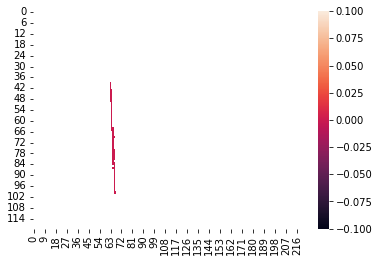

In [ ]:
import seaborn as sns
#selected_elecs = np.load(selection_path, allow_pickle=True)
x_coords = []
y_coords = []
for el in electrodes_by_channels['Channel_0']['Electrodes']: 
    x, y = convert_elno_to_xy(el)
    x_coords.append(x)
    y_coords.append(y)
x_coords = np.array(x_coords)
y_coords = np.array(y_coords)
array = np.zeros((120,220))
array[x_coords, y_coords] = 1
heatmap_grid = np.where(array > 0, 0, np.nan) 
#heatmap_grid = np.where(selected_elecs > 0, 0, np.nan)
sns.heatmap(heatmap_grid)
#np.unique(selected_elecs)

In [ ]:
channels

array([  2,   6,  12,  15,  24,  34,  52,  80,  96,  98, 112, 124, 136,
       146, 156, 158, 164, 168, 184, 186, 196, 212, 214, 224, 230, 240,
       246, 272, 298, 316, 322, 330, 344, 346, 354, 376, 380, 386, 388,
       392, 396, 430, 448, 472, 474, 476, 480, 482, 488, 530, 558, 566,
       568, 572, 576, 578, 584, 588, 642, 696, 698, 702, 768, 770, 786,
       788, 790, 796, 822, 864, 986], dtype=int32)

In [ ]:
from scipy.signal import butter, lfilter

sample_frequency = 20000
cutoff_frequency = 200
filter_order = 2
rawData = h5py.File(recording_path, "r")

nyquist = sample_frequency / 2.
cut_off_discrete = cutoff_frequency / nyquist
coeff_b, coeff_a = butter(filter_order, cut_off_discrete, btype="highpass", analog=False)
traces = rawData.get("sig")[np.squeeze(channels), :]
filtered_traces = lfilter(coeff_b, coeff_a, traces)
np.save(f'/itet-stor/kvulic/neuronies/single_neurons/temp/Giu/filtered_traces_{filename}.npy', filtered_traces)

In [ ]:
filtered_traces = np.load('filtered_traces_1821_N1.npy') 

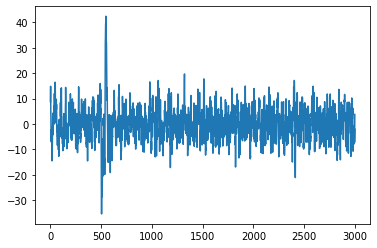

In [ ]:
import matplotlib.pyplot as plt

plt.plot(filtered_traces[0][8000:11000])

In [ ]:
from scipy.signal import find_peaks as fp



In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation, PillowWriter

step = 200
# Voltage data: 4 channels (rows) and 100 time steps (columns)
filtered_traces = np.load('filtered_traces.npy')
filtered_traces = filtered_traces[:,301600:] 

for i in range(0,len(filtered_traces[0])-(step+1),step):

    voltage_data = filtered_traces[:,i:i+step]*6.23
    # Prepare the dictionary with channel info
    #channel_to_coord_dict = {'channel': channels, 'x': x_coords, 'y': y_coords}
    
    channel_to_coord = {ch: (x, y) for ch, x, y in zip(channel_to_coord_dict['channel'], channel_to_coord_dict['x'], channel_to_coord_dict['y'])}

    #channel_to_coord = {
    #ch: (x, y) 
    #for ch, x, y in zip(channel_to_coord_dict['channel'], channel_to_coord_dict['x'], channel_to_coord_dict['y']) 
    #if y > 156
#}

    # Determine the grid size based on the x and y coordinates
    x_max = max(channel_to_coord_dict['x']) + 1
    y_max = max(channel_to_coord_dict['y']) + 1

    # Initialize a grid for the heatmap
    heatmap_grid = np.full((x_max, y_max), np.nan)  # Use NaNs for unoccupied positions

    v_max = filtered_traces.max()
    v_min = filtered_traces.min()
    print(v_max, v_min)

    # Initialize the plot
    grid_kws = {'width_ratios': (0.9, 0.05), 'wspace': 0.01}
    fig, (ax, cbar_ax) = plt.subplots(1, 2,gridspec_kw = grid_kws,figsize=(4, 12))
    #fig, ax = plt.subplots(figsize=(4, 12))

    # Function to update the heatmap for each frame (time step)
    def update(frame):
        ax.clear()
        
        # Copy the grid template to avoid modifying the original NaN grid
        frame_grid = np.copy(heatmap_grid)
        
        # Update the grid with the current voltage values
        for i, (ch, (x, y)) in enumerate(channel_to_coord.items()):
            frame_grid[x, y] = voltage_data[i, frame] # Access voltage for channel i at time step `frame`
        ax.cla()
        #vmax = v_max
        #vmin = v_min
        # Plot the heatmap
        sns.heatmap(frame_grid, annot=False, fmt=".2f", cmap="viridis", vmin = v_min, vmax = v_max, cbar=True, ax=ax,cbar_ax = cbar_ax)  # Adjust vmin/vmax as needed
        #sns.heatmap(frame_grid, annot=False, fmt=".2f", cmap="bwr", cbar=False)
        ax.set_title(f"Channel Voltage Heatmap at Time {frame * 0.05:.2f} ms")  # Assume each frame is 0.05 ms
        ax.set_xlabel("X Coordinate")
        ax.set_ylabel("Y Coordinate")
        ax.set_xlim(20,100)
        ax.set_ylim(60,90)

    # Create the animation
    ani = FuncAnimation(fig, update, frames=voltage_data.shape[1], interval=100, repeat=False)

    # Save the animation as a GIF
    ani.save(f'{filename}_channel_voltage_heatmap_step_{i}.gif', writer=PillowWriter(fps=10))

    # Optionally, display the plot (useful in a notebook environment)
    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'filtered_traces.npy'

141.49845552735405 -168.73083995831126


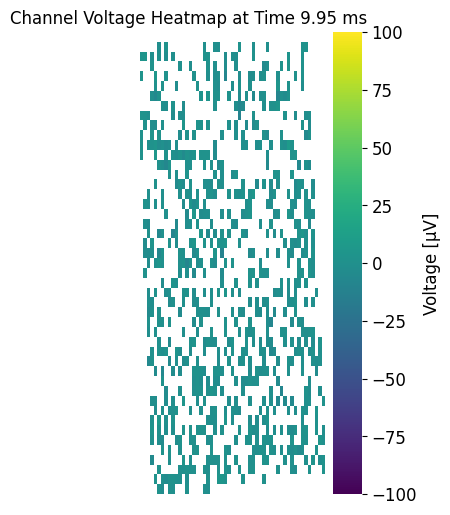

141.49845552735405 -168.73083995831126


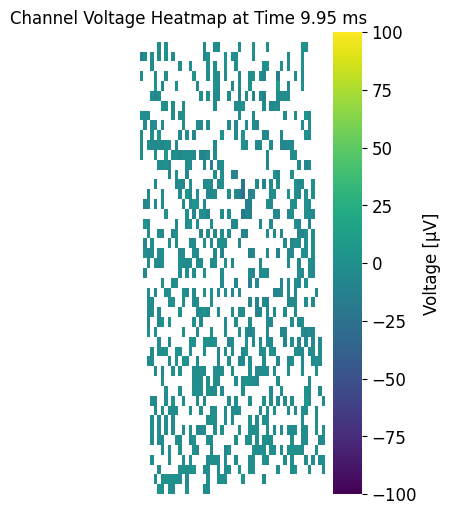

141.49845552735405 -168.73083995831126


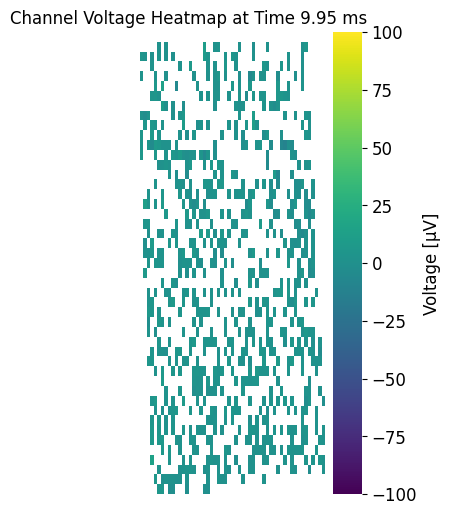

141.49845552735405 -168.73083995831126


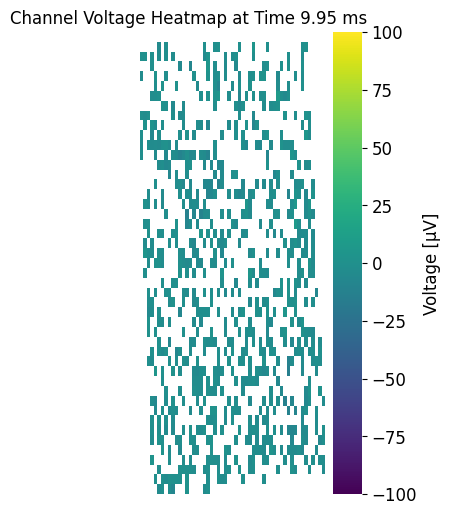

141.49845552735405 -168.73083995831126


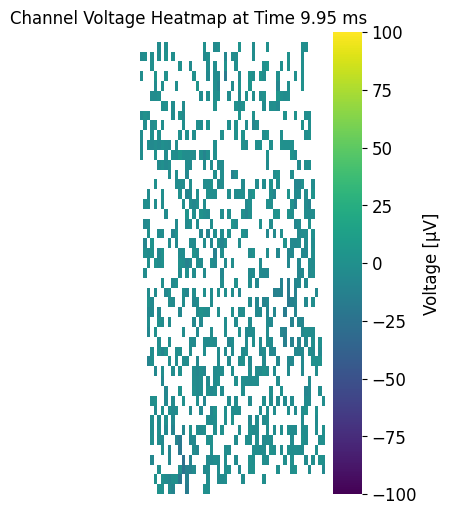

141.49845552735405 -168.73083995831126


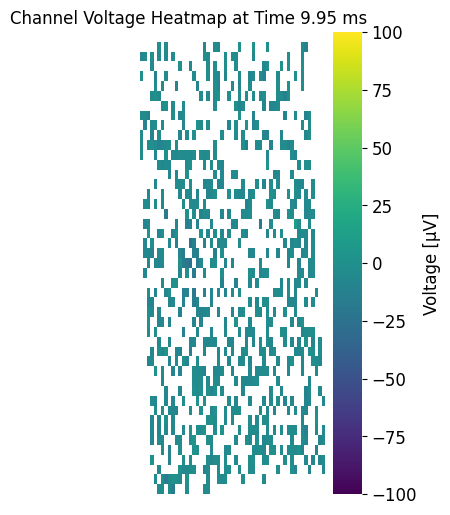

141.49845552735405 -168.73083995831126


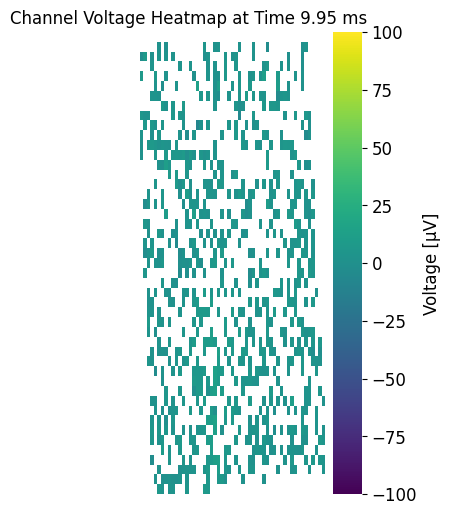

141.49845552735405 -168.73083995831126


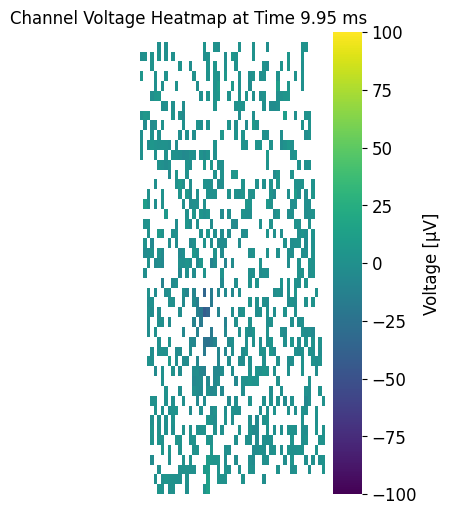

141.49845552735405 -168.73083995831126


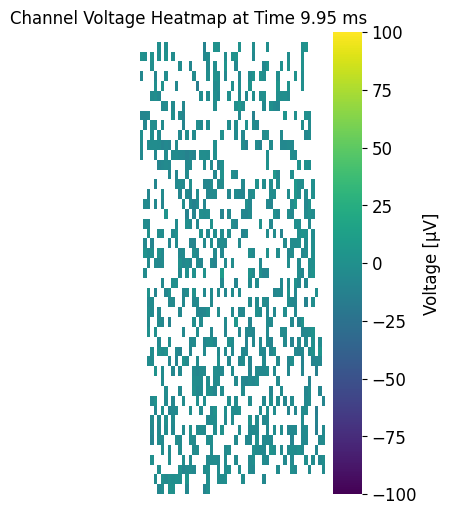

141.49845552735405 -168.73083995831126


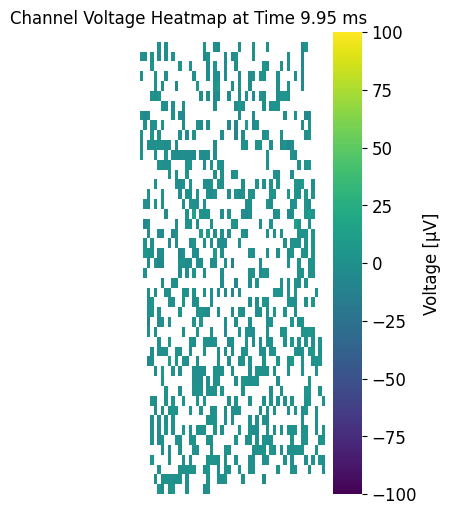

141.49845552735405 -168.73083995831126


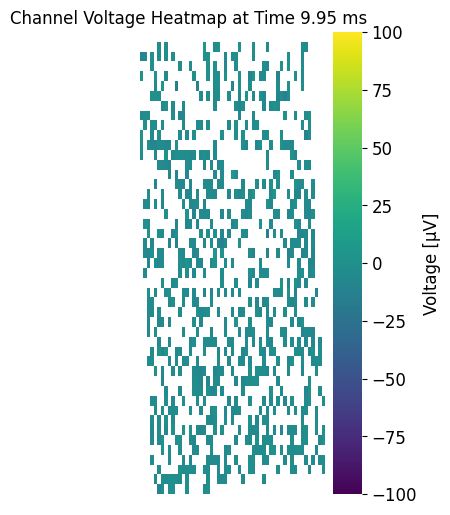

141.49845552735405 -168.73083995831126


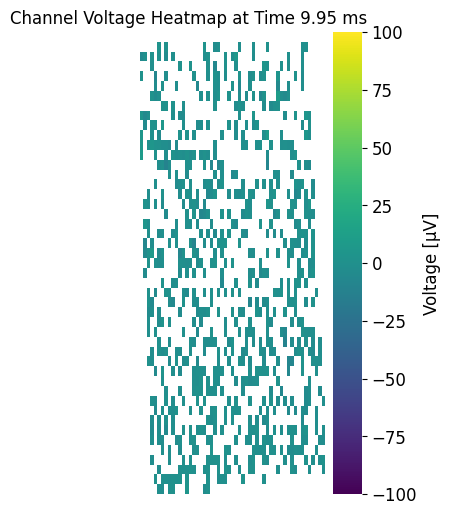

141.49845552735405 -168.73083995831126


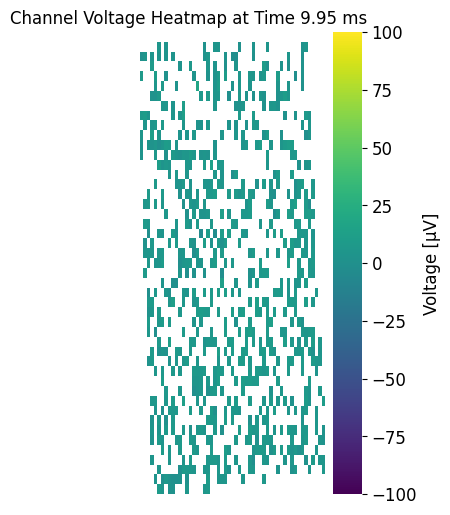

141.49845552735405 -168.73083995831126


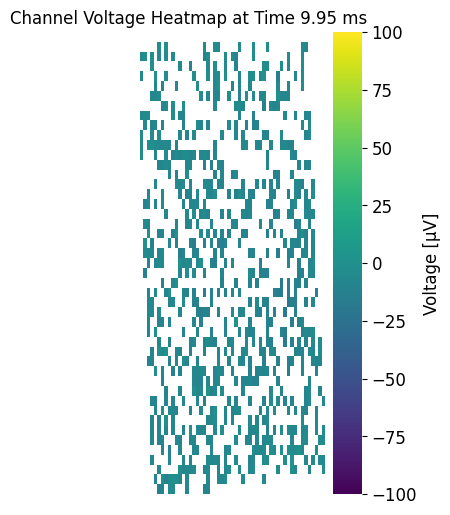

141.49845552735405 -168.73083995831126


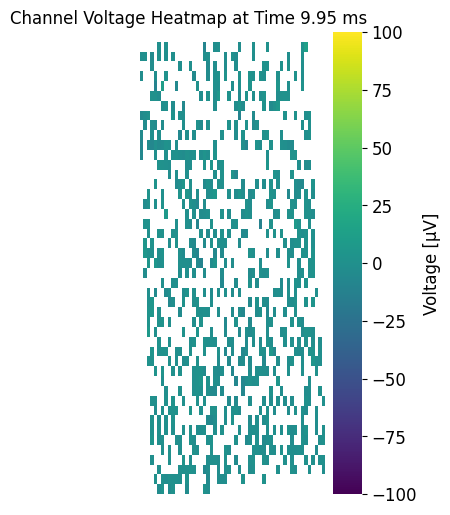

141.49845552735405 -168.73083995831126


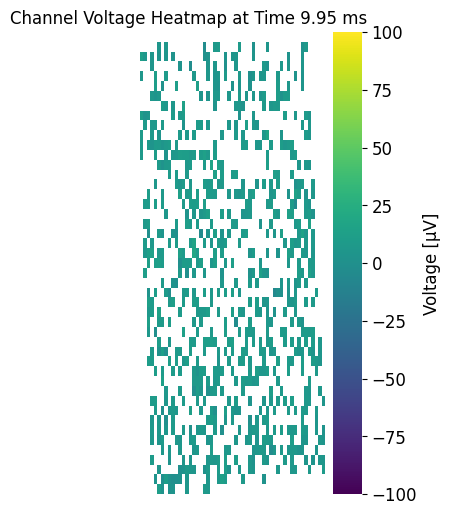

141.49845552735405 -168.73083995831126


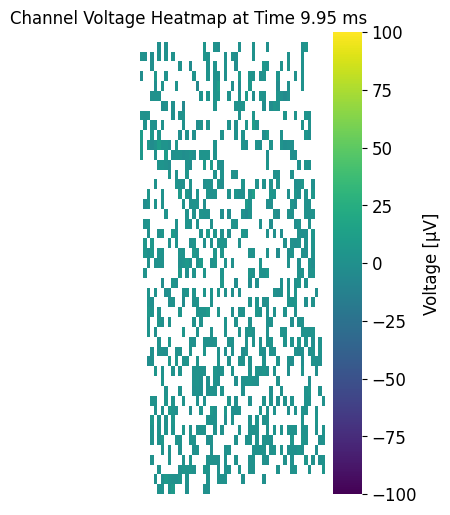

141.49845552735405 -168.73083995831126


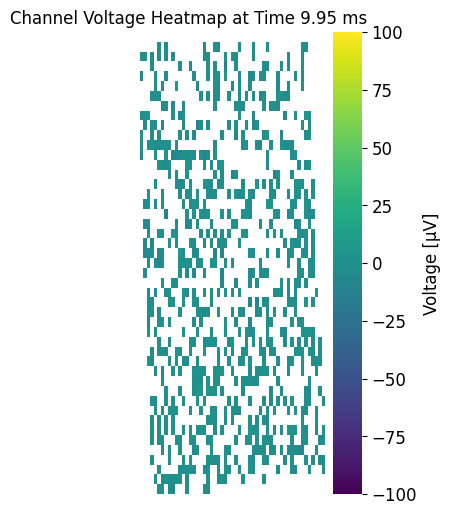

141.49845552735405 -168.73083995831126


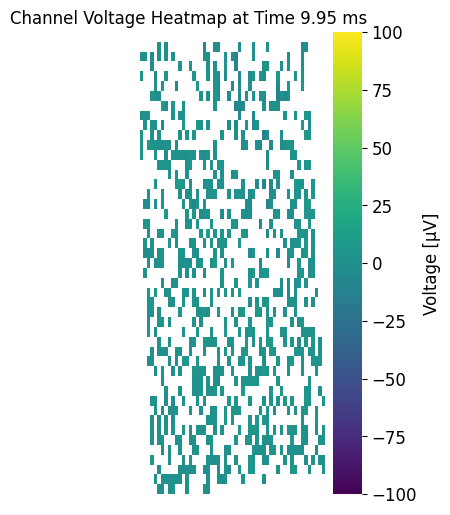

141.49845552735405 -168.73083995831126


KeyboardInterrupt: 

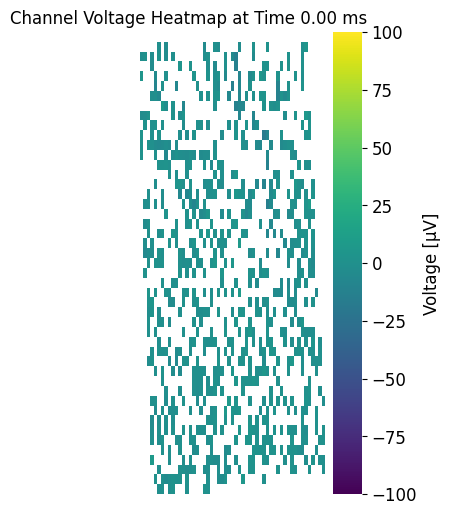

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation, PillowWriter

step = 200
# Voltage data: 4 channels (rows) and 100 time steps (columns)
filtered_traces = np.load(f'/itet-stor/kvulic/neuronies/single_neurons/temp/Giu/filtered_traces_{filename}.npy')
filtered_traces = filtered_traces[:,301600:] 

for i in range(0, len(filtered_traces[0]) - (step + 1), step):

    voltage_data = filtered_traces[:, i:i+step]
    # Prepare the dictionary with channel info
    #channel_to_coord_dict = {'channel': channels, 'x': x_coords, 'y': y_coords}
    
    channel_to_coord = {ch: (x, y) for ch, x, y in zip(channel_to_coord_dict['channel'], channel_to_coord_dict['x'], channel_to_coord_dict['y'])}

    # Determine the grid size based on the x and y coordinates
    x_max = max(channel_to_coord_dict['x']) + 1
    y_max = max(channel_to_coord_dict['y']) + 1

    # Initialize a grid for the heatmap
    heatmap_grid = np.full((x_max, y_max), np.nan)  # Use NaNs for unoccupied positions

    v_max = filtered_traces.max()
    v_min = filtered_traces.min()
    print(v_max, v_min)

    # Initialize the plot
    grid_kws = {'width_ratios': (0.95, 0.1), 'wspace': 0.05}
    fig, (ax, cbar_ax) = plt.subplots(1, 2, gridspec_kw=grid_kws, figsize=(4, 6))

    # Function to update the heatmap for each frame (time step)
    def update(frame):
        ax.clear()
        
        # Copy the grid template to avoid modifying the original NaN grid
        frame_grid = np.copy(heatmap_grid)
        
        # Update the grid with the current voltage values
        for i, (ch, (x, y)) in enumerate(channel_to_coord.items()):
            frame_grid[x, y] = voltage_data[i, frame] # Access voltage for channel i at time step `frame`
        
        ax.cla()
        # Plot the heatmap
        sns.heatmap(frame_grid, annot=False, fmt=".2f", cmap="viridis", vmin=-100, vmax=100, cbar=True, ax=ax, cbar_ax=cbar_ax)
        
        ax.set_title(f"Channel Voltage Heatmap at Time {frame * 0.05:.2f} ms")  # Assume each frame is 0.05 ms
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticks([])
        ax.set_yticks([])
        #ax.set_xlim(156, 170)
        #ax.set_ylim(15, 85)
        
        # Update colorbar properties
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=12)
        cbar.set_label("Voltage [μV]", fontsize=12)

    # Create the animation
    ani = FuncAnimation(fig, update, frames=voltage_data.shape[1], interval=100, repeat=False)

    # Save the animation as a GIF
    ani.save(f'/itet-stor/kvulic/neuronies/single_neurons/temp/Giu/{filename}_channel_voltage_heatmap_step_{i}.gif', writer=PillowWriter(fps=10))

    # Optionally, display the plot (useful in a notebook environment)
    plt.show()


Fixed the looks

In [ ]:


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation, PillowWriter

step = 200
# Voltage data: 4 channels (rows) and 100 time steps (columns)
filtered_traces = np.load(f'/itet-stor/kvulic/neuronies/single_neurons/temp/Giu/filtered_traces_{filename}.npy')
filtered_traces = filtered_traces[:,302000:] 

for i in range(0, len(filtered_traces[0]) - (step + 1), step):

    voltage_data = filtered_traces[:, i:i+step]
    
    channel_to_coord = {ch: (x, y) for ch, x, y in zip(channel_to_coord_dict['channel'], 
                                                       channel_to_coord_dict['x'], 
                                                       channel_to_coord_dict['y'])}

    # Determine the grid size based on the x and y coordinates
    x_max = max(channel_to_coord_dict['x']) + 1
    y_max = max(channel_to_coord_dict['y']) + 1

    # Initialize a grid for the heatmap
    heatmap_grid = np.full((x_max, y_max), np.nan)  # Use NaNs for unoccupied positions

    v_max = filtered_traces.max()
    v_min = filtered_traces.min()
    print(v_max, v_min)

    # Improved figure proportions - increase the width ratio for the main plot
    grid_kws = {'width_ratios': (0.9, 0.05), 'wspace': 0.05}
    fig, (ax, cbar_ax) = plt.subplots(1, 2, gridspec_kw=grid_kws, figsize=(6, 6))

    # Function to update the heatmap for each frame (time step)
    def update(frame):
        ax.clear()
        
        # Copy the grid template to avoid modifying the original NaN grid
        frame_grid = np.copy(heatmap_grid)
        
        # Update the grid with the current voltage values
        for i, (ch, (x, y)) in enumerate(channel_to_coord.items()):
            frame_grid[x, y] = voltage_data[i, frame]
        
        # Plot the heatmap with improved parameters
        sns.heatmap(frame_grid, annot=False, fmt=".2f", cmap="viridis", 
                   vmin=-100, vmax=100, cbar=True, ax=ax, cbar_ax=cbar_ax,
                   square=True)  # Make cells square to avoid distortion
        
        # Improve title formatting
        ax.set_title(f"Channel Voltage Heatmap at Time {frame * 0.05:.2f} ms", fontsize=12)
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Explicitly set the colorbar tick parameters and label
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=10)
        cbar.set_label("Voltage [μV]", fontsize=10)
        
        # Ensure full range of colorbar is visible
        cbar_ax.set_ylim(-100, 100)

    # Create the animation
    ani = FuncAnimation(fig, update, frames=voltage_data.shape[1], interval=100, repeat=False)

    # Save the animation as a GIF
    ani.save(f'/itet-stor/kvulic/neuronies/single_neurons/temp/Giu/{filename}_channel_voltage_heatmap_step_{i}.gif', 
             writer=PillowWriter(fps=10))

    # Display the plot
    plt.close()  # Close the figure after saving to avoid memory issues with multiple plots

In black

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation, PillowWriter

step = 200


# Voltage data: 4 channels (rows) and 100 time steps (columns)
filtered_traces = np.load(f'/itet-stor/kvulic/neuronies/single_neurons/temp/Giu/filtered_traces_{filename}.npy')
filtered_traces = filtered_traces[:,301600:] 

for i in range(0, len(filtered_traces[0]) - (step + 1), step):

    voltage_data = filtered_traces[:, i:i+step]
    
    channel_to_coord = {ch: (x, y) for ch, x, y in zip(channel_to_coord_dict['channel'], 
                                                       channel_to_coord_dict['x'], 
                                                       channel_to_coord_dict['y'])}

    # Determine the grid size based on the x and y coordinates
    x_max = max(channel_to_coord_dict['x']) + 1
    y_max = max(channel_to_coord_dict['y']) + 1

    # Initialize a grid for the heatmap
    heatmap_grid = np.full((x_max, y_max), np.nan)  # Use NaNs for unoccupied positions

    v_max = filtered_traces.max()
    v_min = filtered_traces.min()
    print(v_max, v_min)

    # Set the style to dark background
    plt.style.use('dark_background')
    
    # Improved figure proportions
    grid_kws = {'width_ratios': (0.9, 0.05), 'wspace': 0.05}
    fig, (ax, cbar_ax) = plt.subplots(1, 2, gridspec_kw=grid_kws, figsize=(6, 6))
    
    # Set figure background to black
    fig.patch.set_facecolor('black')

    # Function to update the heatmap for each frame (time step)
    def update(frame):
        ax.clear()
        cbar_ax.clear()
        
        # Copy the grid template to avoid modifying the original NaN grid
        frame_grid = np.copy(heatmap_grid)
        
        # Update the grid with the current voltage values
        for i, (ch, (x, y)) in enumerate(channel_to_coord.items()):
            frame_grid[x, y] = voltage_data[i, frame]
        
        # Plot the heatmap with improved parameters and black background for NaN values
        sns.heatmap(frame_grid, annot=False, fmt=".2f", cmap="viridis", 
                   vmin=-100, vmax=100, cbar=True, ax=ax, cbar_ax=cbar_ax,
                   square=True, mask=np.isnan(frame_grid), cbar_kws={'label': 'Voltage [μV]'})
        
        # Fill in NaN areas with black
        ax.set_facecolor('black')
        
        # Improve title formatting with white text
        ax.set_title(f"Channel Voltage Heatmap at Time {frame * 0.05:.2f} ms", 
                    fontsize=12, color='white')
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Set colorbar text color to white
        cbar = ax.collections[0].colorbar
        cbar.ax.yaxis.set_tick_params(color='white')
        cbar.ax.set_ylabel('Voltage [μV]', color='white')
        for tick in cbar.ax.get_yticklabels():
            tick.set_color('white')
        
        # Ensure colorbar background is also black
        cbar_ax.set_facecolor('black')
        
        # Make sure colorbar shows complete range
        cbar_ax.set_ylim(-100, 100)

    # Create the animation
    ani = FuncAnimation(fig, update, frames=voltage_data.shape[1], interval=100, repeat=False)

    # Save the animation as a GIF with transparent background
    ani.save(f'/itet-stor/kvulic/neuronies/single_neurons/temp/Giu/{filename}_channel_voltage_heatmap_step_{i}.gif', 
             writer=PillowWriter(fps=10))

    # Close the figure after saving
    plt.close()

541.1698293126491 -783.3345485575128
541.1698293126491 -783.3345485575128
541.1698293126491 -783.3345485575128
541.1698293126491 -783.3345485575128
541.1698293126491 -783.3345485575128
541.1698293126491 -783.3345485575128
541.1698293126491 -783.3345485575128
541.1698293126491 -783.3345485575128
541.1698293126491 -783.3345485575128


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fbbfea74190>>
Traceback (most recent call last):
  File "/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


541.1698293126491 -783.3345485575128
541.1698293126491 -783.3345485575128
541.1698293126491 -783.3345485575128


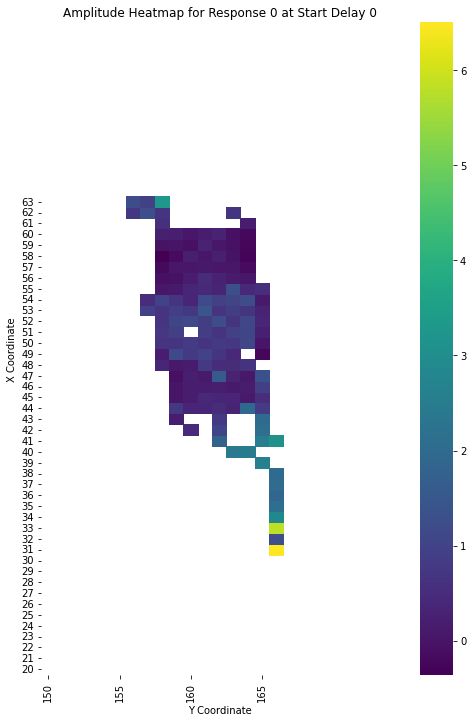

In [ ]:
target_response = 0
start_delay = 0

data = (np.load(os.path.join(data_path,files[-1]), allow_pickle = True))
spikes = data['spikes']

channel_to_coord = {ch: (x, y) for ch, x, y in zip(channel_to_coord_dict['channel'], channel_to_coord_dict['x'], channel_to_coord_dict['y'])}

spikes = spikes.T

# Step 1: Filter data for the target response
filtered_data = spikes[spikes[:, 3] == target_response]

# Step 2: Normalize the delay values to use start_delay as the reference
filtered_data[:, 1] -= start_delay

# Step 3: Prepare a dictionary to store amplitudes with channel coordinates
heatmap_data = {}

# Iterate over filtered data to populate the dictionary with (x, y) coordinates and amplitudes
for row in filtered_data:
    channel, delay, amplitude, response = row
    if channel in channel_to_coord:
        x, y = channel_to_coord[channel]
        if (x, y) not in heatmap_data:
            heatmap_data[(x, y)] = []
        heatmap_data[(x, y)].append(amplitude*1000)

# Average the amplitudes if there are multiple values for the same (x, y) coordinate
for coord in heatmap_data:
    heatmap_data[coord] = np.mean(heatmap_data[coord])

# Prepare a grid to plot the heatmap
# Determine the size of the grid
x_max = max(x for x, y in channel_to_coord.values())
y_max = max(y for x, y in channel_to_coord.values())

# Initialize the grid with NaNs (or some default value)
heatmap_grid = np.full((x_max + 1, y_max + 1), np.nan)

# Populate the grid with amplitude values
for (x, y), amplitude in heatmap_data.items():
    heatmap_grid[x, y] = amplitude

# Step 4: Plot the heatmap
plt.figure(figsize=(8, 12))
sns.heatmap(heatmap_grid, annot=False, fmt=".2f", cmap="viridis", cbar=True)
plt.title(f"Amplitude Heatmap for Response {target_response} at Start Delay {start_delay}")
plt.xlabel("Y Coordinate")
plt.ylim(20,80)
plt.xlim(150,175)
plt.ylabel("X Coordinate")
plt.show()


In [ ]:
heatmap_data_per_delay[delay]

{(47, 164): -0.1584120363221182, (48, 160): -0.09830139632005346}

KeyboardInterrupt: 

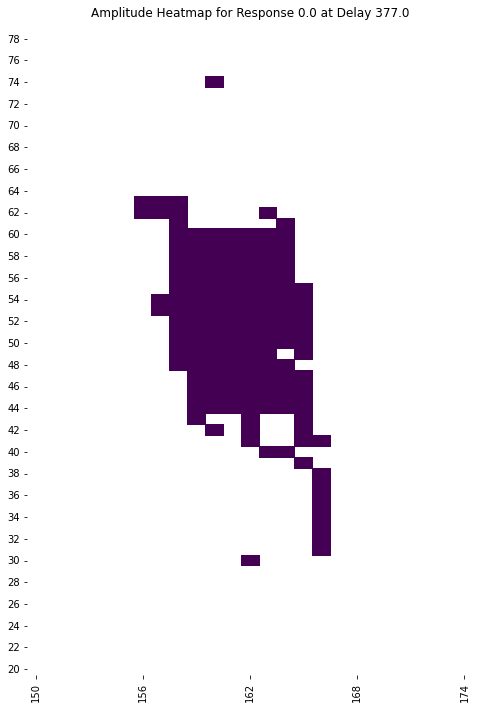

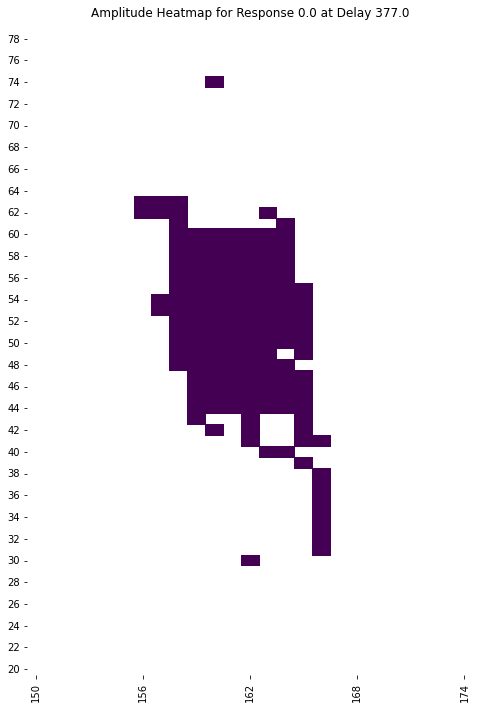

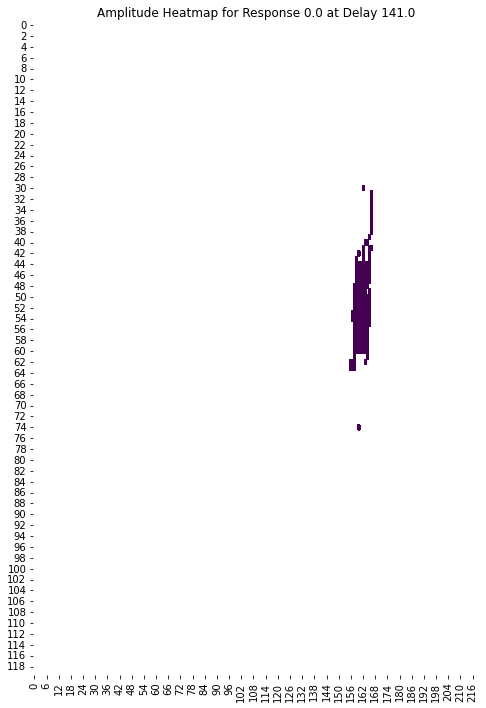

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation, PillowWriter



start_delay = 0

selection_path = 'selection_N1.npy'
selected_elec = np.load(selection_path) 

heatmap_grid = np.where(selected_elec > 0, 0, np.nan)

data = (np.load(os.path.join(data_path,files[-1]), allow_pickle = True))
spikes = data['spikes']

channel_to_coord_dict = {'channel': channels, 'x': elec_coords[:,0], 'y': elec_coords[:,1]}
channel_to_coord = {ch: (x, y) for ch, x, y in zip(channel_to_coord_dict['channel'], channel_to_coord_dict['x'], channel_to_coord_dict['y'])}

spikes = spikes.T
target_response = 0
# Step 1: Filter data for the target response
filtered_data = spikes[spikes[:, 3] == target_response]

# Step 2: Normalize the delay values to use start_delay as the reference
filtered_data[:, 1] -= start_delay

# Step 3: Prepare a dictionary to store amplitudes with channel coordinates for each delay
delay_values = np.unique(filtered_data[:, 1])  # Unique delays
#delay_values = delay_values[:10]
heatmap_data_per_delay = {delay: {} for delay in delay_values}

# Populate the heatmap data per delay
for row in filtered_data:
    channel, delay, amplitude, response = row
    if channel in channel_to_coord:
        x, y = channel_to_coord[channel]
        if (x, y) not in heatmap_data_per_delay[delay]:
            heatmap_data_per_delay[delay][(x, y)] = amplitude*1000

# Determine the grid size
#x_max = max(x for x, y in channel_to_coord.values())
#y_max = max(y for x, y in channel_to_coord.values())
x_max, y_max = selected_elec.shape




# Initialize the plot
fig, ax = plt.subplots(figsize=(8, 12))

# Function to update the heatmap for each frame
def update(frame):
    ax.clear()
    delay = delay_values[frame]
    #heatmap_grid = np.full((x_max + 1, y_max + 1), np.nan)
    frame_grid = np.copy(heatmap_grid)
    #fill heatmap grid with a value 0 for all selected_elecs and the rest of the grid with nan

    amplitudes = []
    for (x, y), amplitude in heatmap_data_per_delay[delay].items():
        #heatmap_grid[x, y] = amplitude
        frame_grid[x, y] = amplitude
        amplitudes.append(amplitude)
    ax.cla()
    vmin = 0
    #sns.heatmap(frame_grid, annot=False, fmt=".2f", cmap="viridis", cbar=False, ax=ax)
    sns.heatmap(frame_grid, annot=False, fmt=".2f", cmap="viridis", cbar=False, ax=ax, vmin=vmin)
    ax.set_title(f"Amplitude Heatmap for Response {target_response} at Delay {delay}")
    ax.set_ylim(20,80)
    ax.set_xlim(150,175)
    #ax.set_xlabel("Y Coordinate")
    #ax.set_ylabel("X Coordinate")

# Create the animation
ani = FuncAnimation(fig, update, frames=len(delay_values), repeat=False)

# Save the animation as a GIF
# This requires `imagemagick` or `pillow` as the writer. Pillow is used here.
ani.save(f"amplitude_heatmap{target_response}.gif", writer=PillowWriter(fps=10))  # Adjust fps as needed

#plt.show()


Loaded 1649_DIV22_N1_amplitude_800_800.npz for plotting
Plotting a movie for response 3.0...
[ 10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  23.  24.  25.  26.
  27.  28.  29.  30.  31.  39.  41.  43.  44. 105. 121. 122. 123. 124.
 143. 144. 145. 146. 153. 154. 160. 166. 168. 169. 170. 171. 172. 174.
 175. 177. 179. 182. 183. 185. 226. 227. 228.]


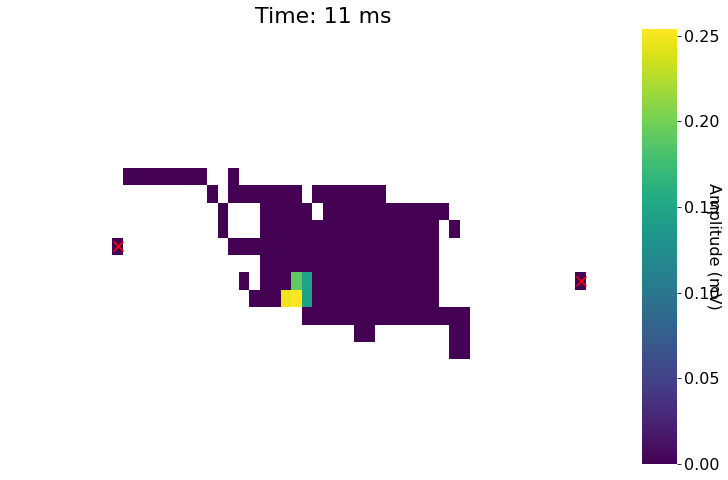

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation, PillowWriter
import os

# Assuming you have defined these variables before
start_delay = 0
selection_path = 'selection_N1.npy'
data_path = "/home/altiki/Documents/LBB/DATA/CMOS/240607_paper_analysis/1649_DIV22_N1_amplitude/processed/"
stimulation_electrode_loc1 = np.array([30,162])
stimulation_electrode_loc2 = np.array([74,160])

files = sorted(os.listdir(data_path))  # Assuming files is a list of file names
channel_to_coord_dict = {'channel': channels, 'x': elec_coords[:,0], 'y': elec_coords[:,1]}
channel_to_coord = {ch: (x, y) for ch, x, y in zip(channel_to_coord_dict['channel'], channel_to_coord_dict['x'], channel_to_coord_dict['y'])}
# Load selected electrodes
selected_elec = np.load(selection_path)
heatmap_grid = np.where(selected_elec > 0, 0, np.nan)
file = files[-1]
data = np.load(os.path.join(data_path, file), allow_pickle=True)
print(f"Loaded {file} for plotting")
# Define your channel_to_coord_dict and other necessary variables here

target_response = 3.0
#for target_response in np.unique(data['spikes'][3]):
if target_response == 3.0:
    print(f"Plotting a movie for response {target_response}...")
    # Filter spikes data for the current target response
    spikes = data['spikes'].T
    filtered_data = spikes[spikes[:, 3] == target_response]
    filtered_data[:, 1] -= start_delay

    # Prepare heatmap data per delay as before (assuming this part remains unchanged)
    delay_values = np.unique(filtered_data[:, 1])
    #delay_values = np.arrange(0.0,10.1, 1.0)
    print(delay_values)
    heatmap_data_per_delay = {delay: {} for delay in delay_values}
    
    for row in filtered_data:
        channel, delay, amplitude, response = row
        if channel in channel_to_coord:
            x, y = channel_to_coord[channel]
            if (x, y) not in heatmap_data_per_delay[delay]:
                heatmap_data_per_delay[delay][(x, y)] = amplitude * 1000
    
    # Initialize the plot
    grid_kws = {'width_ratios': (0.9, 0.05), 'wspace': 0.01}
    fig, (ax, cbar_ax) = plt.subplots(1, 2,gridspec_kw = grid_kws,figsize=(12, 8))
    
    # Function to update the heatmap for each frame
    def update(frame):
        ax.clear()
        delay = delay_values[frame]
        frame_grid = np.copy(heatmap_grid)
    
        amplitudes = []
        for (x, y), amplitude in heatmap_data_per_delay[delay].items():
            frame_grid[x, y] = np.abs(amplitude)
            amplitudes.append(np.abs(amplitude))
        


        frame_grid = np.transpose(frame_grid)

        ax.cla()
        vmin = 0
        vmax = np.max(np.array(amplitudes))
        sns.heatmap(frame_grid, annot=False, fmt=".2f", cmap="viridis", cbar=True, ax=ax,center=(vmin + vmax) / 2., vmin=vmin,cbar_ax = cbar_ax)
        ax.scatter(stimulation_electrode_loc1[0]+0.5, stimulation_electrode_loc1[1] + 0.5, color='red', s=100, marker='x')
        ax.scatter(stimulation_electrode_loc2[0] + 0.5, stimulation_electrode_loc2[1] + 0.5, color='red', s=100, marker='x')
        ax.set_title(f"Time: {int(delay * 0.05)} ms")
        ax.set_ylim(150, 175)  # Adjusted limits after rotation
        ax.set_xlim(20, 80)  # Adjusted limits after rotation
        ax.set_title(f"Time: {int(delay*0.05)} ms", fontsize = 22)
        ax.axis('off')
        ax.set_xticks([])
        ax.set_yticks([])
        cbar_ax.set_ylabel('Amplitude (mV)', rotation=270, labelpad=2, fontsize = 16)
        cbar_ax.tick_params(axis='y', labelsize=16)

        #ax.cla()
        #vmin = 0
        #sns.heatmap(frame_grid, annot=False, fmt=".2f", cmap="viridis", cbar=False, ax=ax, vmin=vmin)
        #ax.scatter(stimulation_electrode_loc1[1]+0.5, stimulation_electrode_loc1[0]+0.5, color='red', s=100, marker='x')
        #ax.scatter(stimulation_electrode_loc2[1]+0.5, stimulation_electrode_loc2[0]+0.5, color='red', s=100, marker='x')
        #ax.set_title(f"Time: {int(delay*0.05)} ms", fontsize = 22)
        #ax.set_ylim(20,80)
        #ax.set_xlim(150,175)
        #ax.axis('off')
        #ax.set_xticks([])
        #ax.set_yticks([])
    
    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(delay_values), repeat=False)
    
    # Save the animation as a GIF for the current target response
    ani.save(f"./100_100_stim/amplitude_heatmap_response_{int(target_response)}.gif", writer=PillowWriter(fps=10))  # Adjust fps as needed
    plt.show()


{10.0: {(42, 160): -2.459080525053922, (32, 166): -0.27059990310510484}, 11.0: {(43, 159): -1.781993425041642, (62, 163): -3.2219705140412973, (41, 162): -0.264488581482676}, 12.0: {(61, 164): -3.09420543694364, (46, 160): -0.3717337040251558, (63, 158): -0.3010768219374204, (45, 159): -0.9055626283108243}, 13.0: {(47, 159): -0.4730116591183946, (47, 161): -0.25773758981533035, (48, 159): -0.26444489928404996, (44, 160): -0.6142883564840494, (44, 159): -0.3375601481915981, (60, 164): -3.034917786005543, (45, 160): -0.5163384943935906, (49, 158): -0.37944890017916266, (45, 161): -0.4173022383725713, (46, 159): -0.5011562750547441, (44, 161): -0.5448920528487422, (48, 158): -0.2839324448782282, (47, 160): -0.2813256145381172}, 14.0: {(60, 163): -0.8784549404021974, (59, 164): -2.127255695866447, (44, 162): -0.4290267971370637, (48, 160): -0.16350244738365166}, 15.0: {(59, 163): -0.8536507988989886}, 16.0: {(40, 164): 0.3767638030161575, (57, 164): -1.4298696700979923, (34, 166): 0.258055

IndexError: list index out of range

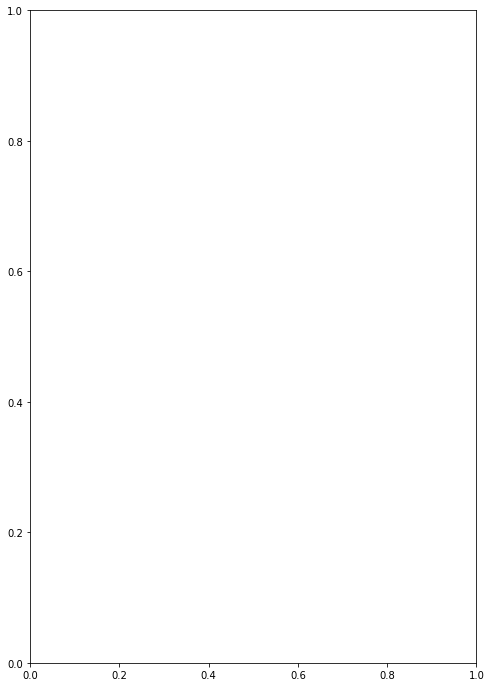

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation, PillowWriter

#target_response = 2
start_delay = 0

selection_path = 'selection_N1.npy'
selected_elec = np.load(selection_path) 

heatmap_grid = np.where(selected_elec > 0, 0, np.nan)

data = (np.load(os.path.join(data_path,files[-1]), allow_pickle = True))
spikes = data['spikes']

channel_to_coord_dict = {'channel': channels, 'x': elec_coords[:,0], 'y': elec_coords[:,1]}
channel_to_coord = {ch: (x, y) for ch, x, y in zip(channel_to_coord_dict['channel'], channel_to_coord_dict['x'], channel_to_coord_dict['y'])}

spikes = spikes.T

# Step 1: Filter data for the target response
#filtered_data = spikes[spikes[:, 3] == target_response]
filtered_data = spikes

# Step 2: Normalize the delay values to use start_delay as the reference
filtered_data[:, 1] -= start_delay

delay_values = np.unique(spikes[:, 1])  # Unique delays
avg_amplitude_per_delay = {delay: {} for delay in delay_values}


# Populate the average amplitude data per delay
for row in spikes:
    channel, delay, amplitude, response = row
    #y, x = divmod(channel, 220)  # Convert channel to (y, x) coordinates assuming 220 columns
    if channel in channel_to_coord:  # Only consider coordinates in the selection
        if (x, y) not in avg_amplitude_per_delay[delay]:
            avg_amplitude_per_delay[delay][(x, y)] = []
        avg_amplitude_per_delay[delay][(x, y)].append(amplitude)

# Compute the average amplitude for each (x, y) coordinate and delay
for delay, coords in avg_amplitude_per_delay.items():
    for coord, amplitudes in coords.items():
        avg_amplitude_per_delay[delay][coord] = np.mean(amplitudes)

# Determine the grid size from the selection array dimensions
y_max, x_max = selected_elec.shape

print(heatmap_data_per_delay)
# Initialize the plot
fig, ax = plt.subplots(figsize=(8, 12))

# Function to update the heatmap for each frame
def update(frame):
    ax.clear()
    delay = delay_values[frame]
    #heatmap_grid = np.full((x_max + 1, y_max + 1), np.nan)
    frame_grid = np.copy(heatmap_grid)
    #fill heatmap grid with a value 0 for all selected_elecs and the rest of the grid with nan

    #heatmap_grid = np.where(selected_elecs!=0)
    for (x, y), amplitude in heatmap_data_per_delay[delay].items():
        #heatmap_grid[x, y] = amplitude
        frame_grid[x, y] = amplitude
    ax.cla()
    #sns.heatmap(heatmap_grid, annot=False, fmt=".2f", cmap="viridis", cbar=False, ax=ax)
    sns.heatmap(frame_grid, annot=False, fmt=".2f", cmap="viridis", cbar=False, ax=ax)
    ax.set_title(f"Amplitude Heatmap for Response {target_response} at Delay {delay}")
    ax.set_ylim(20,80)
    ax.set_xlim(150,175)
    #ax.set_xlabel("Y Coordinate")
    #ax.set_ylabel("X Coordinate")

# Create the animation
ani = FuncAnimation(fig, update, frames=len(delay_values), repeat=False)

# Save the animation as a GIF
# This requires `imagemagick` or `pillow` as the writer. Pillow is used here.
ani.save("amplitude_heatmap.gif", writer=PillowWriter(fps=10))  # Adjust fps as needed

plt.show()

Loaded 1649_DIV22_N1_amplitude_800_800.npz for plotting
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
13
14
15
40
40
44
44
44
50
54
57
59
60
60
61
96
96
98
98
98
105
105
106
106
107
107
107
107
107
108
108
108
108
108
108
108
108
110
112
113
121
121
122
123
125
126
126
127
127
127
127
127
128
128
128
128
128
129
129
129
132
134
136
137
138
138
139
139
139
139
139
140
140
141
141
142
142
146
147
147
158
160
197
198
198
198
199
200
200
200
200
200
200
201
201
207
208
209
209
209
209
209
221
225
225
225
227
227
259
259
260
261
263
263
263
263
267
267
268
268
268
268
268
268
268
268
268
268
269
269
269
270
270
270
270
270
270
270
270
270
270
270
270
270
270
270
271
271
271
271
271
271
271
272
272
272
272
296
298
299
299
302
302
303
303


ValueError: zero-size array to reduction operation maximum which has no identity

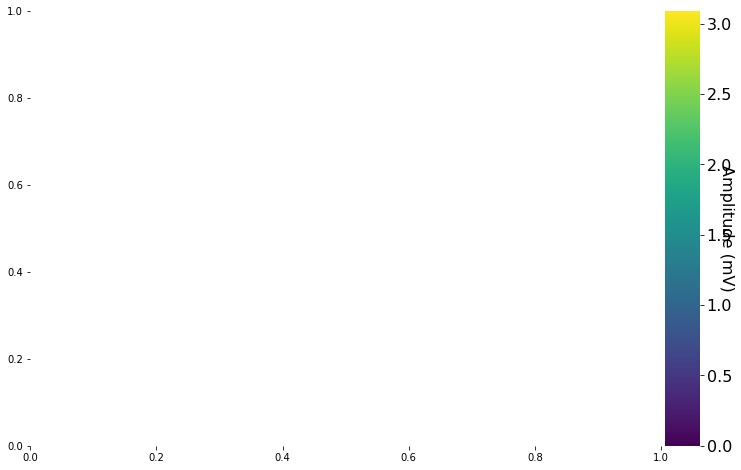

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation, PillowWriter
import os

# Assuming these variables are defined earlier in your code
start_delay = 0
selection_path = 'selection_N1.npy'
data_path = "/home/altiki/Documents/LBB/DATA/CMOS/240607_paper_analysis/1649_DIV22_N1_amplitude/processed/"
stimulation_electrode_loc1 = np.array([30, 162])
stimulation_electrode_loc2 = np.array([74, 160])

# Read the files
files = sorted(os.listdir(data_path))
channel_to_coord_dict = {'channel': channels, 'x': elec_coords[:, 0], 'y': elec_coords[:, 1]}
channel_to_coord = {ch: (x, y) for ch, x, y in zip(channel_to_coord_dict['channel'], channel_to_coord_dict['x'], channel_to_coord_dict['y'])}
# Load selected electrodes
selected_elec = np.load(selection_path)
heatmap_grid = np.where(selected_elec > 0, 0, np.nan)

# Load the data file
file = files[-1]
data = np.load(os.path.join(data_path, file), allow_pickle=True)
print(f"Loaded {file} for plotting")

# Define target delay range (0 to 10 ms)
delay_step = 0.05  # 50 µs step (20 kHz sampling rate, 1 unit = 0.05 ms)
max_delay = 10  # Maximum delay in ms
delay_values = np.arange(0, max_delay / delay_step)  # Delay values in steps (0 to 200)



# Filter spikes data
spikes = data['spikes'].T
filtered_data = spikes[spikes[:, 1] >= start_delay]
filtered_data[:, 1] -= start_delay

# Initialize dictionary to accumulate amplitudes for each coordinate and delay
heatmap_data_per_delay = {delay: {} for delay in delay_values}

for row in filtered_data:
    channel, delay, amplitude, response = row
    if channel in channel_to_coord:
        x, y = channel_to_coord[channel]
        delay_step_index = int(delay)  # Assuming delay is in units of 0.05 ms
        print(delay_step_index)
        if delay_step_index < max_delay:
            if (x, y) not in heatmap_data_per_delay[delay_step_index]:
                heatmap_data_per_delay[delay_step_index][(x, y)] = []
            heatmap_data_per_delay[delay_step_index][(x, y)].append(amplitude * 1000)  # Convert to mV

# Calculate the mean amplitude for each coordinate and delay
mean_heatmap_data_per_delay = {
    delay: {coord: np.mean(amplitudes) for coord, amplitudes in coords_amplitudes.items()}
    for delay, coords_amplitudes in heatmap_data_per_delay.items()
}

# Initialize the plot
grid_kws = {'width_ratios': (0.9, 0.05), 'wspace': 0.01}
fig, (ax, cbar_ax) = plt.subplots(1, 2, gridspec_kw=grid_kws, figsize=(12, 8))

# Function to update the heatmap for each frame
def update(frame):
    ax.clear()
    delay = delay_values[frame]
    frame_grid = np.copy(heatmap_grid)

    amplitudes = []
    for (x, y), amplitude in mean_heatmap_data_per_delay[delay].items():
        frame_grid[x, y] = np.abs(amplitude)
        amplitudes.append(np.abs(amplitude))

    frame_grid = np.transpose(frame_grid)

    vmin = 0
    vmax = np.max(np.array(amplitudes))
    sns.heatmap(frame_grid, annot=False, fmt=".2f", cmap="viridis", cbar=True, ax=ax,
                center=(vmin + vmax) / 2., vmin=vmin, cbar_ax=cbar_ax)
    ax.scatter(stimulation_electrode_loc1[0] + 0.5, stimulation_electrode_loc1[1] + 0.5, color='red', s=100, marker='x')
    ax.scatter(stimulation_electrode_loc2[0] + 0.5, stimulation_electrode_loc2[1] + 0.5, color='red', s=100, marker='x')
    ax.set_title(f"Time: {int(delay * 0.05)} ms", fontsize=22)
    ax.set_ylim(150, 175)  # Adjusted limits after rotation
    ax.set_xlim(20, 80)  # Adjusted limits after rotation
    ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    cbar_ax.set_ylabel('Amplitude (mV)', rotation=270, labelpad=2, fontsize=16)
    cbar_ax.tick_params(axis='y', labelsize=16)

# Create the animation
ani = FuncAnimation(fig, update, frames=len(delay_values), repeat=False)

# Save the animation as a GIF
output_path = "./100_100_stim/amplitude_heatmap_mean_response.gif"
ani.save(output_path, writer=PillowWriter(fps=10))  # Adjust fps as needed
plt.show()

print(f"Animation saved to {output_path}")


In [ ]:
import os
import h5py
import numpy as np
import sys
from collections import Counter
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

In [ ]:
sample_frequency = 20000
cutoff_frequency=200
filter_order=2

In [ ]:
def get_electrode_channel_mapping(raw_data) -> np.array:
    """
    Retrieves electrode-to-channel mapping from the HDF5 file.

    :param raw_data: The HDF5 file data.
    :return: A np.array containing the electrode to channel mapping.
    """
    # Get the clean absolute and relative indices of the spiking information.
    electrode_info = np.asarray(raw_data["mapping"]["channel", "electrode"])
    mask = [i["electrode"] != -1 for i in electrode_info]
    clean_abs_ids = np.asarray([i[0]["electrode"][i[1]] for i in zip(electrode_info, mask)], dtype=np.int32)
    clean_rel_ids = np.asarray([i[0]["channel"][i[1]] for i in zip(electrode_info, mask)], dtype=np.int32)

    # Map the relative indices to the absolute indices of the spiking information
    electrode_channel_mapping = np.zeros([2, clean_rel_ids.shape[0]], dtype=np.int32)
    electrode_channel_mapping[0, :] = np.squeeze(clean_abs_ids)
    electrode_channel_mapping[1, :] = np.squeeze(clean_rel_ids)

    del electrode_info
    del mask
    del clean_abs_ids
    del clean_rel_ids

    return electrode_channel_mapping

In [ ]:
raw_path = '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Small_Network_Plasticity/3_Processed_Data/BCM_Test/241206_test_rec/'
recordings = sorted(os.listdir(raw_path))
processed_path = '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Small_Network_Plasticity/3_Processed_Data/BCM_Test/241206_sorters_test/'
processed = sorted([f for f in os.listdir(processed_path) if f.endswith('.raw_processed.pkl')])
processed,recordings

In [ ]:
raw_data = h5py.File(os.path.join(raw_path, recordings[0]), "r")
processed_data = np.load(os.path.join(processed_path, processed[0]), allow_pickle=True)
processed_data['SPIKEMAT']
electrodes = [row[0] for row in processed_data['SPIKEMAT']]
most_common_electrode = Counter(electrodes).most_common(1)[0]
most_common_electrode

In [ ]:
electrode_to_channel = get_electrode_channel_mapping(raw_data)

In [ ]:
index = np.where(electrode_to_channel[0] == int(most_common_electrode[0]))[0][0]
electrode_to_channel[1,index]

In [ ]:
traces = raw_data.get("sig")[np.squeeze(electrode_to_channel[1,index]), :]
if traces.ndim == 1:
                traces = np.expand_dims(traces, axis=0)

In [ ]:
filtered_spike_mat = [row for row in processed_data['SPIKEMAT'] if row[0] == most_common_electrode[0]]

In [ ]:
nyquist = sample_frequency/2.
cut_off_discrete = cutoff_frequency / nyquist
coeff_b, coeff_a = butter(filter_order, cut_off_discrete, btype="highpass", analog=False)
traces = lfilter(coeff_b, coeff_a, traces)

In [ ]:
second_elements = np.array([row[1] for row in filtered_spike_mat])
filtered_spike_mat_dist = [row for row in filtered_spike_mat if abs(row[1] - second_elements[0]) < 1.0]
filtered_spike_mat_dist

In [ ]:
x_ms = np.arange(0,len(traces[0])/sample_frequency,1/sample_frequency)*1000
plt.plot(x_ms[5000:10000], traces[0][5000:10000])
plt.scatter(second_elements, np.ones(len(filtered_spike_mat))*100, color='red')

In [ ]:
import pickle 
with open('/itet-stor/kvulic/neuronies/single_neurons/3_Student_Projects/Amelie/Processed_data/Amelie_analysis/Chip1908/Chip1908_DIV42', 'wb') as f:
    pickle.load(f, 'ID1908_N0_DIV42_DATE20241204_1552_spontaneous_NGN2.raw_processed.pkl')